## The following notebook simulates the different mass-motor combinations of Aurora


In [10]:
from rocketpy import Environment, SolidMotor, Flight, Rocket
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sin, cos, radians
import re
file = "V002.eng"

#### env

In [11]:
def wind(wdir, wvel):
    e = Environment(latitude=47.117819, longitude=19.341037)
    wdir_rad = radians(wdir)
    ucomp = -wvel * sin(wdir_rad)
    vcomp = -wvel * cos(wdir_rad)
    grad = 1.5
    
    tmp_grad = 6.5
    e.set_atmospheric_model(
        type="custom_atmosphere",
        pressure=None,
        temperature=[[0, 288.15], [1000, 288.15-tmp_grad], [2000, 288.15-2*tmp_grad]],
        wind_u=[(110, ucomp), (1000, ucomp), (2000, ucomp)],
        wind_v=[(110, vcomp), (1000, vcomp), (2000, vcomp)],
    )
    return e

In [12]:
env = wind(300,4)
env.max_expected_height = 3400
#env.prints.launch_site_details()
#env.plots.atmospheric_model()

#### Read off

In [13]:
def read_off_thrust(file_path, start_line, end_line):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
            lines = lines[start_line:end_line]
            thrust_curve = []
            for line in lines:
                thrust_curve.append([float(x) for x in line.split()])
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return []
    return thrust_curve

In [14]:
def read_off_value(file_path, text, unit=None):
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Check if the line contains the specified text
                if text in line:
                    # Regular expression to extract the number(s) with or without the specified unit
                    if unit:
                        pattern = rf"; {re.escape(text)}\s+\({re.escape(unit)}\):\s+([\d.\s]+)"
                    else:
                        pattern = rf"; {re.escape(text)}\s*:\s+([\d.\s]+)"
                    
                    match = re.search(pattern, line)
                    if match:
                        values = match.group(1).strip().split()
                        # Convert the values to float or int
                        values = [round(float(value), 4) if '.' in value else int(value) for value in values]
                        # Return a single value if only one value is found
                        return values[0] if len(values) == 1 else values
        raise ValueError(f"Text '{text}' with unit '{unit}' not found in the file.")
    except FileNotFoundError:
        print(f"Error: The file at {file_path} was not found.")
    except ValueError as ve:
        print(f"Error: {ve}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [15]:
# Calculating the average spacer size
spacer_sizes = read_off_value(file, "Spacer Sizes", "mm")
avg_spacer_size = sum(spacer_sizes) / len(spacer_sizes) / 1000

In [16]:
def read_grain_values(file_path, value_type):
    values = []
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Regular expression to extract the specified value for each grain
                if value_type == "length":
                    match = re.search(r"Grain #\d+:.*Length=([\d.]+) mm", line)
                elif value_type == "density":
                    match = re.search(r"Grain #\d+:.*Density=([\d.]+) kg/m\^3", line)
                elif value_type == "id":
                    match = re.search(r"Grain #\d+:.*ID=([\d.]+) mm", line)
                elif value_type == "od":
                    match = re.search(r"Grain #\d+:.*OD=([\d.]+) mm", line)
                elif value_type == "inhib":
                    match = re.search(r"Grain #\d+:.*Inhib=([\d.]+) mm", line)
                else:
                    raise ValueError("Invalid value type specified. Use 'length' or 'density'.")
                
                if match:
                    value = float(match.group(1))
                    values.append(round(value, 4))
        
        if not values:
            raise ValueError(f"No {value_type} values found in the file.")
        return values
    except FileNotFoundError:
        print(f"Error: The file at {file_path} was not found.")
    except ValueError as ve:
        print(f"Error: {ve}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

#### Motor

In [17]:
Kratos = SolidMotor(
   thrust_source=read_off_thrust(file, 26, 280),
   dry_mass=read_off_value(file, "Hardware Mass", "kg"), # changed
   dry_inertia=(1.138, 0.012, 1.138),
   nozzle_radius=read_off_value(file, "Nozzle Exit Diameter") / 2000, # changed
   grain_number=read_off_value(file, "Number of Grains"), # changed
   grain_density=read_grain_values(file, "density")[0], # changed
   grain_outer_radius=read_grain_values(file, "od")[0] / 2000, # changed
   grain_initial_inner_radius=read_grain_values(file, "id")[0] / 2000, # changed
   grain_initial_height=read_off_value(file, "Total Propellant Length", "mm") / 1000 / read_off_value(file, "Number of Grains"),
   grain_separation=avg_spacer_size,
   grains_center_of_mass_position=read_off_value(file, "Total Propellant Length", "mm") / 2000, # changed
   center_of_dry_mass_position=read_off_value(file, "Total Motor Length", "mm") / 2000, # changed
   nozzle_position=-14/100,
   burn_time=read_off_thrust(file, 269, 270)[0][0], # changed
   throat_radius=read_off_value(file, "Nozzle Throat Diameter") / 2000, # changed
   coordinate_system_orientation="nozzle_to_combustion_chamber",
   interpolation_method='linear'
)
print(read_off_thrust(file, 269, 270)[0][0]) # changed
print(read_off_value(file, "Number of Grains"))

2.43
6


In [18]:
Kratos.prints.grain_details()

Grain Details
Number of Grains: 6
Grain Spacing: 0.007 m
Grain Density: 1785.0 kg/m3
Grain Outer Radius: 0.0495 m
Grain Inner Radius: 0.0175 m
Grain Height: 0.13083333333333333 m
Grain Volume: 0.001 m3
Grain Mass: 1.573 kg



In [11]:
print(f"Motor total mass [kg]: {str(Kratos.total_mass(0))}")

Motor total mass [kg]: 19.042080719034512


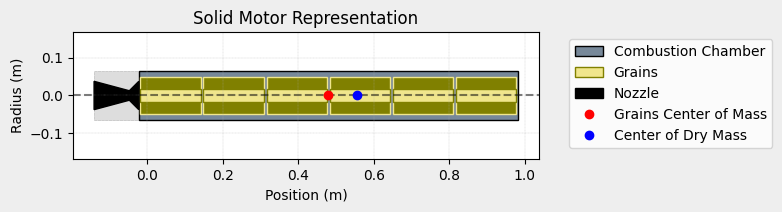

Nozzle Details
Nozzle Radius: 0.0375 m
Nozzle Throat Radius: 0.0125 m

Grain Details
Number of Grains: 6
Grain Spacing: 0.007 m
Grain Density: 1785.0 kg/m3
Grain Outer Radius: 0.0495 m
Grain Inner Radius: 0.0175 m
Grain Height: 0.16 m
Grain Volume: 0.001 m3
Grain Mass: 1.924 kg

Motor Details
Total Burning Time: 2.43 s
Total Propellant Mass: 11.542 kg
Structural Mass Ratio: 0.394
Average Propellant Exhaust Velocity: 1170.143 m/s
Average Thrust: 5557.980 N
Maximum Thrust: 5799.9 N at 1.11 s after ignition.
Total Impulse: 13505.890 Ns



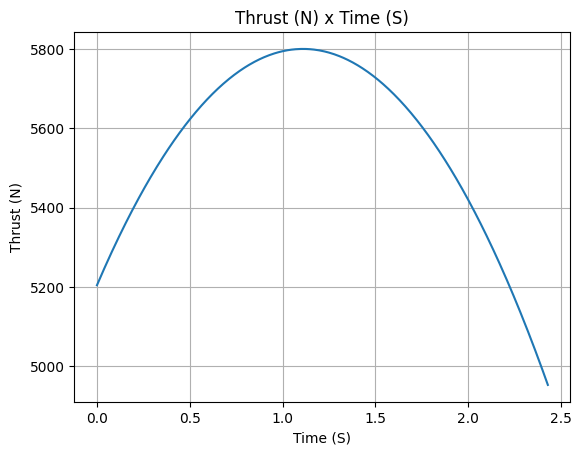

In [12]:
Kratos.draw()
Kratos.info()

#### Constant

In [13]:
# Launch constants
direction = 315
inclination = 83
worst_inclination = 45
rail_length = 8

rocket_mass = [25, 26, 27, 28, 29, 30]

print(f"Rocket Mass Without Motor: {rocket_mass} kg")
    
print("Loaded Motor Mass: {:.4} kg".format(Kratos.total_mass(0)))

for i in rocket_mass:
    print("Fully loaded Rocket Mass: {:.4} kg".format(i + Kratos.total_mass(0)))

Rocket Mass Without Motor: [25, 26, 27, 28, 29, 30] kg
Loaded Motor Mass: 19.04 kg
Fully loaded Rocket Mass: 44.04 kg
Fully loaded Rocket Mass: 45.04 kg
Fully loaded Rocket Mass: 46.04 kg
Fully loaded Rocket Mass: 47.04 kg
Fully loaded Rocket Mass: 48.04 kg
Fully loaded Rocket Mass: 49.04 kg


#### Rocket

In [14]:
Motor_initial_mass = Kratos.total_mass(0),                                      # [kg]
#CG_pos = 1189,
CG_pos = 1600,

In [16]:
# Saját az Openrocket alapján

Aurora = Rocket(
    radius = 160 / 2000,
    mass = 34.458,
    inertia = (21.427460, 21.427460, 0.131263),
    power_off_drag = "Max_01_off.csv",
    power_on_drag = "Max_01_on.csv",
    center_of_mass_without_motor = CG_pos[0] / 1000,
    coordinate_system_orientation = "tail_to_nose"
)

Aurora.add_motor(
    motor = Kratos, 
    position = 0 / 1000
)

Aurora.set_rail_buttons(
    upper_button_position = 853 / 1000,
    lower_button_position = 136.5 / 1000,
    angular_position = 45
)

Aurora.add_nose(
    length = 320 / 1000,
    kind = "von karman",
    position = 3770 / 1000,                                                     # Pitot tube is excluded [m]
    bluffness = 0
)

Aurora.add_trapezoidal_fins(
    n = 4,
    root_chord = 400 / 1000,
    tip_chord = 100 / 1000,
    span = 180 / 1000,
    position = 501.5 / 1000,
    cant_angle = 0,
    sweep_length = 280 / 1000,
    airfoil=("naca0004.csv", "degrees"),
    name = "fins"
)

Aurora.add_tail(
    top_radius = 150 / 2000, 
    bottom_radius = 130 / 2000, 
    length = 80 / 1000, 
    position = 0 / 1000
)

Aurora.add_parachute(
    name = "drogue",
    cd_s = 0.85,
    trigger = "apogee",
    sampling_rate = 200,
    lag = 3,
    noise = (0, 0, 0)
)

main_parachute_=Aurora.add_parachute(
    name = "main",
    cd_s = 19.8,
    trigger = 450,
    sampling_rate = 200,
    lag = 3,
    noise = (0, 0, 0)
)

In [17]:
#print(f"Prometheus Nominal total mass [kg]: {str(Aurora.total_mass(0))}")
print(f"Aurora Nominal total mass [kg]: {str(Aurora.total_mass(0))}")    

Aurora Nominal total mass [kg]: 53.500080719034514


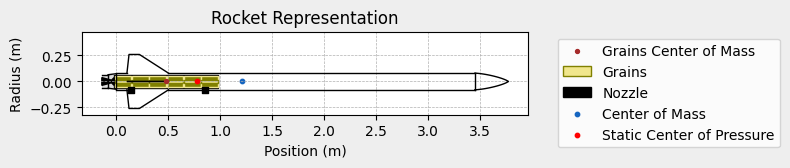

In [18]:
Aurora.draw()

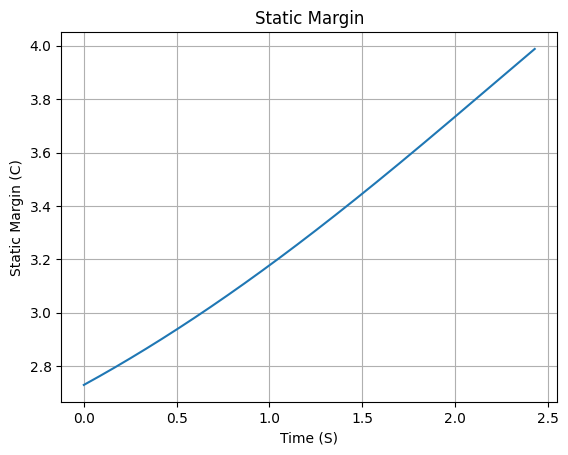

In [19]:
Aurora.static_margin()

#### Fligth

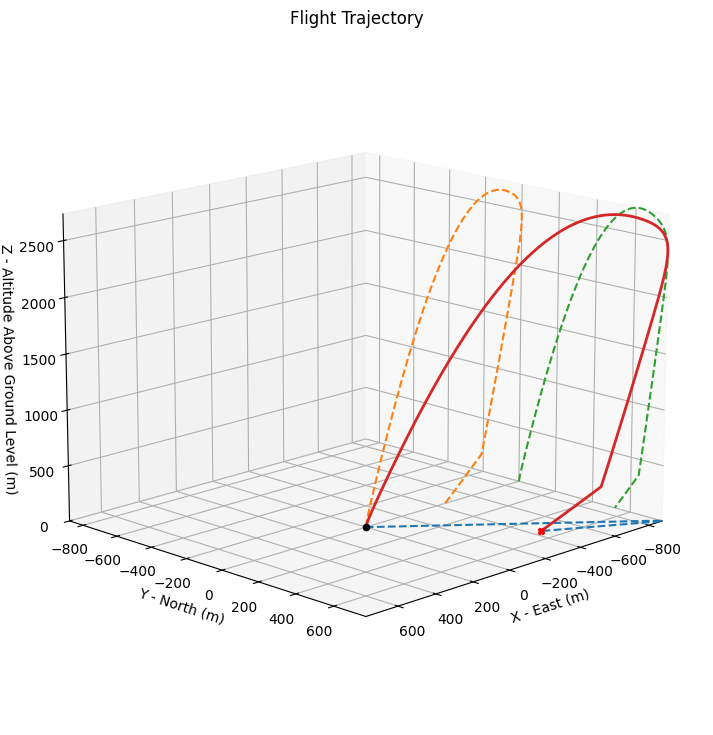


Apogee State

Apogee Time: 23.820 s
Apogee Altitude: 2732.134 m (ASL) | 2732.134 m (AGL)
Apogee Freestream Speed: 41.468 m/s
Apogee X position: -721.405 m
Apogee Y position: 622.023 m
Apogee latitude: 47.1234164°
Apogee longitude: 19.3314957°


In [20]:
# Simulate the flight.

flight = Flight(
    environment = env,
    rocket = Aurora,
    rail_length = rail_length,
    inclination = inclination,
    heading = direction,
    name=f"Nominal",
)
flight.plots.trajectory_3d()
flight.prints.apogee_conditions()

#### az

In [115]:
flight.prints.out_of_rail_conditions()
flight.prints.burn_out_conditions()


Rail Departure State

Rail Departure Time: 0.392 s
Rail Departure Velocity: 36.390 m/s
Rail Departure Stability Margin: 2.890 c
Rail Departure Angle of Attack: 6.151°
Rail Departure Thrust-Weight Ratio: 10.955
Rail Departure Reynolds Number: 4.059e+05

Burn out State

Burn out time: 2.430 s
Altitude at burn out: 296.986 m (ASL) | 296.986 m (AGL)
Rocket speed at burn out: 254.336 m/s
Freestream velocity at burn out: 255.151 m/s
Mach Number at burn out: 0.752
Kinetic energy at burn out: 1.357e+06 J


RESULTS

In [116]:
import numpy as np

# Égési idő lekérdezése és megfelelő formátumba alakítása
burn_time = Aurora.motor.burn_duration
if isinstance(burn_time, tuple):  # Ha tuple, az első elemet használjuk
    burn_time = burn_time[0]

# Stabilitás kiszámítása 1 mp-vel az égés után
stability_after_burn = flight.stability_margin(burn_time + 1)

# Eredmények kiírása
print(f"Burnout Time: {burn_time:.2f} s")
print(f"Stability Margin 1s After Burnout: {stability_after_burn:.2f} cal")


Burnout Time: 2.43 s
Stability Margin 1s After Burnout: 3.99 cal


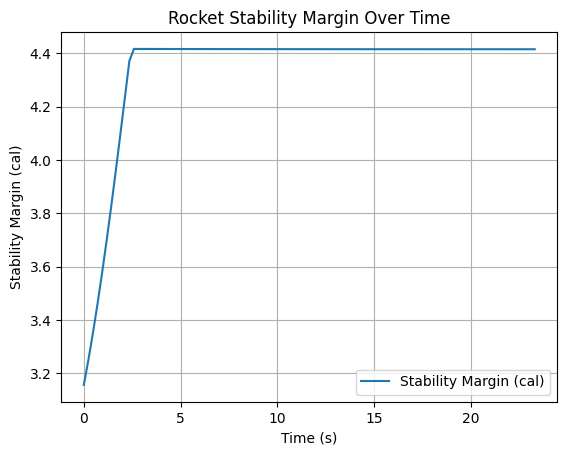

In [108]:
import numpy as np
import matplotlib.pyplot as plt

times = np.linspace(0, flight.apogee_time, 100)  # 0-tól az apogeumig 100 pontban
stability_margins = [flight.stability_margin(t) for t in times]

plt.plot(times, stability_margins, label="Stability Margin (cal)")
plt.xlabel("Time (s)")
plt.ylabel("Stability Margin (cal)")
plt.title("Rocket Stability Margin Over Time")
plt.legend()
plt.grid()
plt.show()

In [117]:
print(file)
print(f"{Aurora.mass} kg")
flight.prints.maximum_values()
flight.prints.apogee_conditions()
print(f"{flight.impact_velocity} m/s")



HELIOS-1-V2-V001.eng
34.458 kg

Maximum Values

Maximum Speed: 254.335 m/s at 2.43 s
Maximum Mach Number: 0.752 Mach at 2.43 s
Maximum Reynolds Number: 2.731e+06 at 2.43 s
Maximum Dynamic Pressure: 3.877e+04 Pa at 2.43 s
Maximum Acceleration During Motor Burn: 111.565 m/s² at 1.55 s
Maximum Gs During Motor Burn: 11.377 g at 1.55 s
Maximum Acceleration After Motor Burn: 9.993 m/s² at 18.97 s
Maximum Gs After Motor Burn: 1.019 Gs at 18.97 s
Maximum Stability Margin: 3.990 c at 2.43 s
Maximum Upper Rail Button Normal Force: 9.014 N
Maximum Upper Rail Button Shear Force: 2.433 N
Maximum Lower Rail Button Normal Force: 16.913 N
Maximum Lower Rail Button Shear Force: 4.566 N

Apogee State

Apogee Time: 23.328 s
Apogee Altitude: 2636.778 m (ASL) | 2636.778 m (AGL)
Apogee Freestream Speed: 40.331 m/s
Apogee X position: -689.448 m
Apogee Y position: 594.955 m
Apogee latitude: 47.1231728°
Apogee longitude: 19.3319184°
-5.823357171927155 m/s


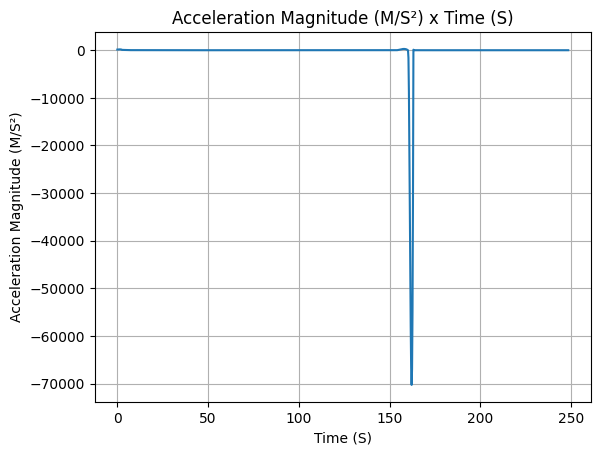

In [29]:
flight.acceleration()